# Primeiro teste com Raspberry (Jupyter remoto)

Instruções de como acessar o Jupyter da raspberry: https://amber-md.github.io/pytraj/latest/tutorials/remote_jupyter_notebook

### Importações

Deu tanto trabalho corrigir a versão do Python e instalar os pacotes com as dependências batendo que se a célula abaixo rodar já é motivo de muita alegria.

In [1]:
import llvmlite
import numba
import numpy as np
import scipy
import sklearn
import librosa
import pyaudio
import wave
from IPython.display import Audio

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Deu warning mas tudo bem

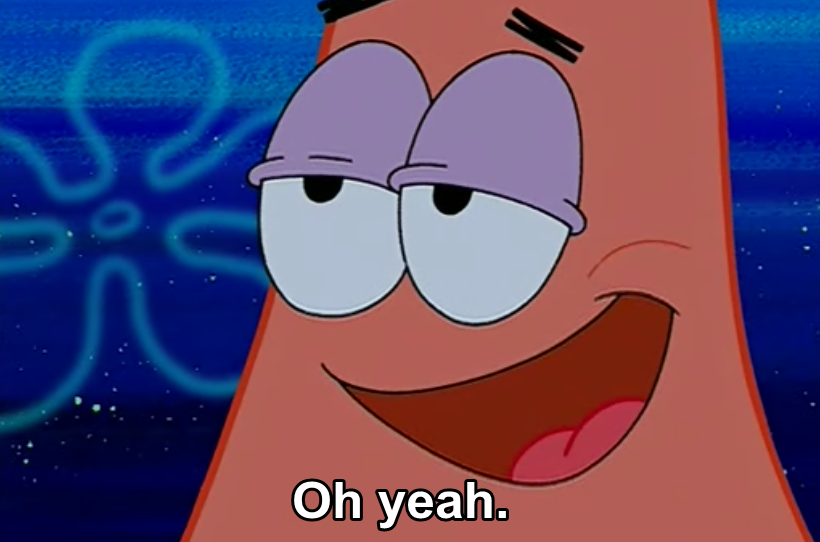

In [2]:
from IPython.display import Image
Image("https://i.kym-cdn.com/photos/images/original/000/604/727/3e7.png", width=300)

### Deletando as importações que eu não preciso pra limpar a memória

In [3]:
del llvmlite
del numba
del scipy
del sklearn

# Granvando um áudio com a raspberry

A função abaixo foi implementada em https://wiki.seeedstudio.com/ReSpeaker_4_Mic_Array_for_Raspberry_Pi/#extract-voice

In [4]:
def listarDispositivos():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')

    for i in range(0, numdevices):
            if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
                print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

In [5]:
listarDispositivos()

Input Device id  0  -  seeed-4mic-voicecard: bcm2835-i2s-ac10x-codec0 ac10x-codec.1-003b-0 (hw:1,0)
Input Device id  3  -  ac108
Input Device id  5  -  default


Beleza, sabemos que o ID dos microfones é o 0. Para capturar o áudio, o entendimento do que cada variável significa pode ser visto em: https://stackoverflow.com/questions/35970282/what-are-chunks-samples-and-frames-when-using-pyaudio

In [6]:
# PARAMETROS INICIAIS 
# O INDEX ACABAMOS DE VER ALI EM CIMA 
# A PROFUNDIDADE NAO E EM BITS E EM BYTES, POR ISSO 2 (16 bits)
# NÃO FICA LEGAL COM 8 BITS APENAS, DA ALGUMA COISA DE ERRADO
# TAMANHOJANELA CHAMAVA-SE CHUNK. VAMOS GRAVAR JANELAS DE 200 MS
# TEMPO DE GRAVACAO ESTA EM SEGUNDOS
respeakerIndex          = 0
respeakerFreqAmostragem = 16000
respeakerProfundidade   = 2
respeakerCanais         = 4
tamanhoJanela           = int(0.200 * respeakerFreqAmostragem)
tempoGravacao           = 10
nomeArquivoWAVSaida     = "/home/pi/GravacoesReSpeaker/gravacaoPython.wav"
 
# INSTANCIANDO UM OBJ PY AUDIO E MANDANDO OS PARAMETROS INICIAIS
objPyAudio = pyaudio.PyAudio()
stream = objPyAudio.open(
    input_device_index = respeakerIndex,
    rate               = respeakerFreqAmostragem,
    format             = objPyAudio.get_format_from_width(respeakerProfundidade),
    channels           = respeakerCanais,
    input=True    
)
 
# GRANVANDO
print("INICIANDO A GRAVAÇÃO")
 
janelas = []
 
for i in range(0, int(respeakerFreqAmostragem/tamanhoJanela * tempoGravacao)):
    janelaAtual = stream.read(tamanhoJanela)
    janelas.append(janelaAtual)
    
print("GRAVAÇÃO FINALIZADA")
 
# MATANDO OS OBJETOS PRA LIMPAR MEMORIA
stream.stop_stream()
stream.close()
objPyAudio.terminate()

INICIANDO A GRAVAÇÃO
GRAVAÇÃO FINALIZADA


Nesse ponto, temos um array chamado **janelas** que contém todas as janelas de 200ms gravadas. Entretanto, o conteúdo é binário. Precisamos da biblioteca **wave** para "traduzir" a informação em um arquivo .wav, ou podemos usar o numpy para traduzir aqui mesmo e não ter que gravar um .wav e abrir de novo.

# Ouvindo a gravação

### Usando o classe wave para gravar um .wav e abrindo o arquivo com o librosa pra ouvir a gravação

In [9]:
# SALVANDO O ARQUIVO WAV POIS O ARRAY JANELAS E BINARIO, NAO DA PRA OUVIR DIRETO DELE
wf = wave.open(nomeArquivoWAVSaida, 'wb')
wf.setnchannels(respeakerCanais)
wf.setsampwidth(objPyAudio.get_sample_size(objPyAudio.get_format_from_width(respeakerProfundidade)))
wf.setframerate(respeakerFreqAmostragem)
wf.writeframes(b''.join(janelas))
wf.close()

# ABRINDO O ARQUIVO WAV GRAVADO USANDO A CLASSE LIBROSA
arraySinais, freqAmostragem = librosa.load(nomeArquivoWAVSaida, sr=None, mono=False)
print(arraySinais.shape)
print(freqAmostragem)

(4, 160000)
16000


In [15]:
# OUVINDO
Audio(data=arraySinais[0], rate=freqAmostragem)

### Usando o numpy pra traduzir a informação binária e não ter que salvar um arquivo wav pra abrir de novo

In [16]:
# DEFININDO A MATRIZ DO SOM GRAVADO. CADA LINHA UM MIC, CADA COLUNA UMA AMOSTRA
matrizSinaisInt16 = []
for i in range(respeakerCanais):
    matrizSinaisInt16.append([])

# PASSANDO POR CADA JANELA GRAVADA (CADA JANELA TEM 4 SINAIS, UM DE CADA MIC)
for janelaBinariaAtual in janelas:
    
    # CONVERTO A JANELA ATUAL PRA INT 16
    janelaAtualInt16 = np.fromstring(janelaBinariaAtual, dtype=np.int16)
    
    # COMO TEM OS 4 MICS NA JANELA, VOU DAR UM RESHAPE PRA CADA MIC FICAR EM UMA LINHA
    # MAS A janelaAtualInt16 DO PASSO ANTERIOR VEM DA SEGUINTE FORMA:
    # [amostra0Mic0, amostra0Mic1, amostra0Mic2, amostra0Mic3, amostra1Mic0, amostra1Mic1, 
    #  amostra1Mic2,  amostra1Mic3,  amostra2Mic0,  amostra2Mic1,  amostra2Mic2, ...]
    # POR ISSO TENHO QUE PRIMEIRO ORDENAR COM SHAPE (tamanhoJanela, respeakerCanais)
    # E DEPOIS TRANSPOR A MATRIZ. DESSA FORMA, CADA LINHA VAI SER UM MIC...
    janelaAtualInt16 = janelaAtualInt16.reshape((tamanhoJanela, respeakerCanais)).T
    
    # PASSANDO POR CADA MIC
    for indexMicAtual, janelaMicAtual in enumerate(janelaAtualInt16):
        
        # COLOCO A JANELA ATUAL DO MIC ATUAL NA MATRIZ DE SINAIS
        matrizSinaisInt16[indexMicAtual].extend(janelaMicAtual)
        
# PASSANDO A MATRIZ DE SINAIS PRA NUMPY E VERIFICANDO A DIMENSIONALIDADE
matrizSinaisInt16 = np.array(matrizSinaisInt16)
print("A matriz deve ter", respeakerCanais, "linhas e", tamanhoJanela * len(janelas), "colunas.")
print("Dimensionalidade da matriz:", matrizSinaisInt16.shape)

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


A matriz deve ter 4 linhas e 160000 colunas.
Dimensionalidade da matriz: (4, 160000)


In [17]:
# OUVINDO O RESULTADO
Audio(data=matrizSinaisInt16[1], rate=respeakerFreqAmostragem)